In [2]:
import numpy as np
from matplotlib import pyplot as plt
import myfuncs as mf
import healpy as hp
from pixell import enmap
import orphics
from orphics import maps

In [3]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# Loading

In [4]:
PROJECT_PATH = "/project/r/rbond/ymehta3/"
PRODUCTS_PATH = PROJECT_PATH + "output/lensresponse/gerrit/"
PLOTDIR = '/project/r/rbond/ymehta3/output/lensresponse/'

In [5]:
factor_list = [32, 64, 128]

In [6]:
R_names = ['R2_smoothed_32.npy', 'R2_smoothed_64.npy', 'R2_smoothed_128.npy']
Rs = []
for R_name in R_names:
    R_current = np.load(PRODUCTS_PATH + R_name)
    R_current = np.where(R_current == 0., np.nan, R_current)
    Rs.append(R_current)
    
var_names = ['okappa_var_32.npy', 'okappa_var_64.npy', 'okappa_var_128.npy']
var_list = []
for var_name in var_names:
    var_list.append(np.load(PRODUCTS_PATH + var_name))

In [7]:
okappa_sims_path = '/scratch/r/rbond/gfarren/unWISExACT_outputs/sims/kappa/'
okappa_sim_name_path = PROJECT_PATH + 'input_data/kappa_sims/' + 'okappas_gerrit.txt'

with open(okappa_sim_name_path) as kalmfile:
    kalm_name = kalmfile.readlines()[0].rstrip('\n')
    kappa_alm = hp.read_alm(okappa_sims_path + kalm_name)
    kappa_alm = np.cdouble(kappa_alm)

In [8]:
kappa_mask_name_path = '/project/r/rbond/ymehta3/input_data/' + 'name_dr6mask.txt'

kmask = mf.readMap(kappa_mask_name_path)

In [9]:
error_path = PRODUCTS_PATH

Cl_kk_unweighted_list = {}
Cl_kk_weighted_list = {}
cov_unweighted_list = {}
cov_weighted_list = {}
err_weighted_list = {}
err_unweighted_list = {}

for factor in factor_list:
    Cl_kk_unweighted_list[factor] = np.load(error_path + 'avgCl_kk_unweighted_' + str(factor) + '.npy')
    Cl_kk_weighted_list[factor] = np.load(error_path + 'avgCl_kk_weighted_' + str(factor) + '.npy')
    cov_unweighted_list[factor] = np.load(error_path + 'cov_kk_unweighted_' + str(factor) + '.npy')
    cov_weighted_list[factor] = np.load(error_path + 'cov_kk_weighted_' + str(factor) + '.npy')
    err_weighted_list[factor] = np.std(np.load(error_path + 'Cls_kk_weighted_' + str(factor) + '.npy'), axis=0)
    err_unweighted_list[factor] = np.std(np.load(error_path + 'Cls_kk_unweighted_' + str(factor) + '.npy'), axis=0)

In [10]:
ells = np.arange(len(var_list[0]))
iellmax = ells[-1] + 1

BINSIZE = 32
ells_bin, _ = mf.binning(BINSIZE, ells, np.ones(ells.shape))

kappa_lm = mf.idx2lm(kappa_alm)

w4 = mf.wn(kmask, 4)

In [11]:
Cls_kk_sig = np.load(PRODUCTS_PATH + 'input_avgCl_kk.npy')
Cls_kk_sig = Cls_kk_sig[:int(1000/BINSIZE)]

# Calculations

## Create Weights

Create m-dependent weights from the variance of the response function-corrected kappa field. Note that ```var``` is the variance of the $\kappa$, and ```var**2``` is the variance of the $C^{\kappa\kappa}_{\ell}$.

In [12]:
#Create Normalized Weights
W2_list = []
norm_list = []
for var in var_list:
    W2_unweighed = 1 / var.copy()**2
#     W2_unweighed = np.tril(np.ones(var.shape)**2)
#     W2_unweighed = np.where(W2_unweighed == 0, np.nan, W2_unweighed)
    norm2 = np.nansum(2 * W2_unweighed[:, 1:], axis=-1)  +  W2_unweighed[:, 0]
    norm_list.append(norm2)
#     W2_list.append(W2_unweighed / norm2[..., None])
    W2_list.append(W2_unweighed)

In [ ]:
plt.plot(ells, W2_list[-1]/norm2, label='norm')
# plt.plot(ells, testnorm1, label='test 1')
# plt.plot(ells, testnorm2, '--', label='test 2')

plt.legend();

## Create kappa auto power spectra with and without weights.

In [9]:
Cl_kk_unweighted_list = []

for R in Rs:
    #Calculation
    kappa_alm_response = mf.lm2idx(kappa_lm / R)
    Cl_kappa = hp.alm2cl(kappa_alm_response) / w4
    
    #Binning
    ells_bin, Cl_kk_bin = mf.binning(BINSIZE, ells, Cl_kappa[:iellmax])
    
    Cl_kk_unweighted_list.append(Cl_kk_bin)

/tmp/ipykernel_85840/3295535697.py:5: RuntimeWarning: divide by zero encountered in true_divide
  kappa_alm_response = mf.lm2idx(kappa_lm / R)
/tmp/ipykernel_85840/3295535697.py:5: RuntimeWarning: invalid value encountered in true_divide
  kappa_alm_response = mf.lm2idx(kappa_lm / R)


In [13]:
Cl_kk_weighted_list = []

for i, W2 in enumerate(W2_list):
    #Calculations
    kappa_alm_response = (kappa_lm / Rs[i])[:iellmax, :iellmax]
    Cl_kk_weighted = np.real( kappa_alm_response * np.conjugate(kappa_alm_response) )
    Cl_kk_weighted = mf.lm2cl(Cl_kk_weighted, weights= W2) / w4
#     Cl_kk_weighted = mf.lm2cl(Cl_kk_weighted) / w4

    
    #Binning
    ells_bin, Cl_weighted_bin = mf.binning(BINSIZE, ells, Cl_kk_weighted)
    
    Cl_kk_weighted_list.append(Cl_weighted_bin)

/tmp/ipykernel_85840/2419864588.py:5: RuntimeWarning: divide by zero encountered in true_divide
  kappa_alm_response = (kappa_lm / Rs[i])[:iellmax, :iellmax]
/tmp/ipykernel_85840/2419864588.py:5: RuntimeWarning: invalid value encountered in true_divide
  kappa_alm_response = (kappa_lm / Rs[i])[:iellmax, :iellmax]


## Aside

Proof that my ```lm2cl``` function works.

In [39]:
Cl_test = mf.lm2cl(kappa_lm * np.conjugate(kappa_lm)) / w4

/scinet/niagara/software/2019b/opt/base/python/3.9.8/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


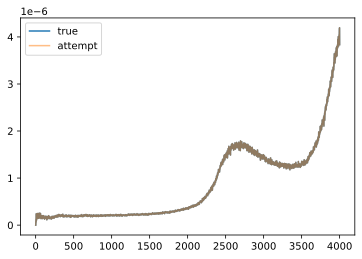

In [41]:
plt.plot(np.arange(len(Cl_kappa)), hp.alm2cl(kappa_alm)/w4, label='true')
plt.plot(np.arange(len(Cl_kappa)), Cl_test, alpha=.5 , label='attempt')

plt.legend();

### Errors

# Plots

Response function-corrected kappa variances:

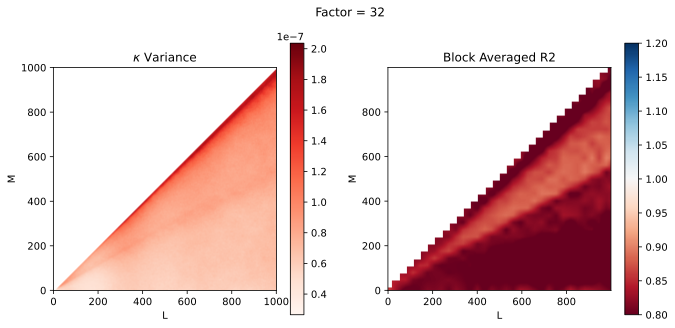

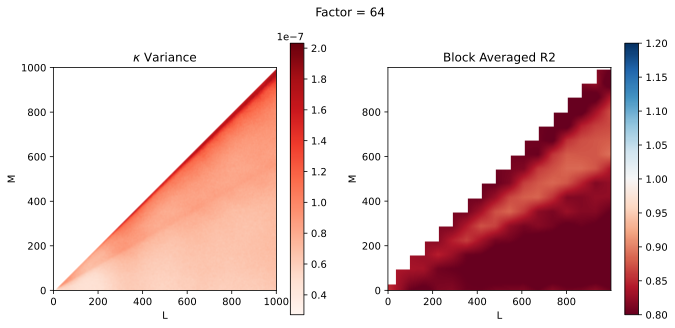

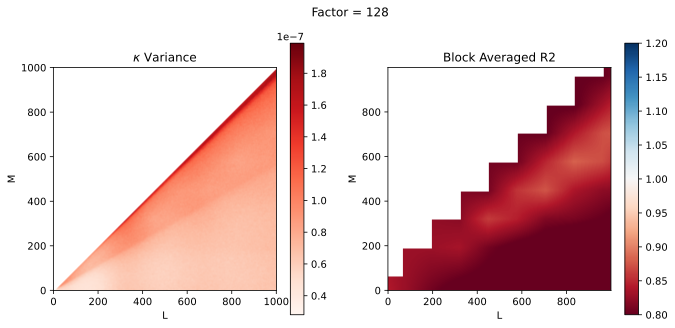

In [88]:
cbar_range1 = [0.8, 1.2]
cbar_range2 = [0.8, 1.2]

for i, R in enumerate(Rs):
    fig, ax = plt.subplots(1,2, figsize=(11,5))
    
    im = ax[0].imshow(np.transpose(var_list[i]), cmap='Reds', origin='lower')
    ax[0].set_xlabel('L')
    ax[0].set_ylabel('M')
    ax[0].set_title(r'$\kappa$ Variance')
    plt.colorbar(im, ax=ax[0])

    im2 = ax[1].imshow(np.transpose(R[:1000, :1000]), clim=cbar_range2, cmap='RdBu', origin='lower')
    ax[1].set_xlabel('L')
    ax[1].set_ylabel('M')
    ax[1].set_title('Block Averaged R2')
    plt.colorbar(im2, ax=ax[1])
    
    fig.suptitle(f'Factor = {factor_list[i]}');
    
    fig.savefig(PLOTDIR + 'var_R2_' + str(factor_list[i]) + '_gerrit.png', bbox_inches='tight', dpi=400)

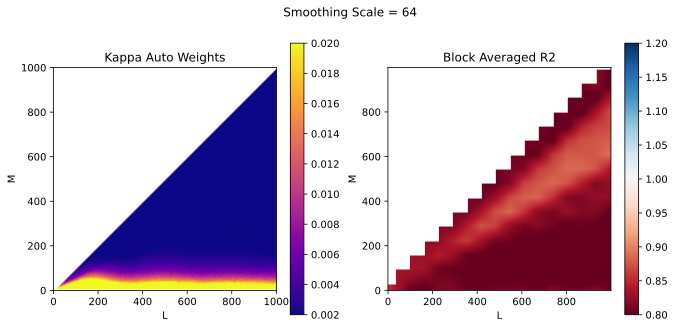

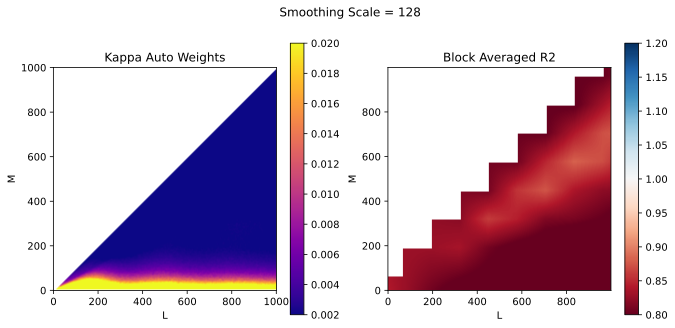

In [147]:
cbar_range1 = [2e-3, 2e-2]
cbar_range2 = [0.8, 1.2]

for i, W2 in enumerate(W2_list):
    
    if factor_list[i] == 32:
        continue
    
    fig, ax = plt.subplots(1,2, figsize=(11,5))
    
#     im = ax.imshow(np.transpose(W2/norm_list[i]), cmap='Reds', origin='lower')
    im1 = ax[0].imshow(np.transpose(W2/norm_list[i]), clim= cbar_range1, cmap='plasma', origin='lower')
    ax[0].set_xlabel('L')
    ax[0].set_ylabel('M')
    ax[0].set_title(f'Kappa Auto Weights')
    plt.colorbar(im1, ax=ax[0])
    
    im2 = ax[1].imshow(np.transpose(Rs[i][:1000, :1000]), clim=cbar_range2, cmap='RdBu', origin='lower')
    ax[1].set_xlabel('L')
    ax[1].set_ylabel('M')
    ax[1].set_title('Block Averaged R2')
    plt.colorbar(im2, ax=ax[1])
    
    fig.suptitle(f'Smoothing Scale = {factor_list[i]}');

In [155]:
np.transpose(Rs[1][:1000, :1000])

array([[0.85644269, 0.85589361, 0.85534453, ..., 0.80634904, 0.80634402,
        0.80633899],
       [0.85624405, 0.85570045, 0.85515685, ..., 0.80591983, 0.805915  ,
        0.80591016],
       [0.85604542, 0.85550729, 0.85496917, ..., 0.80549062, 0.80548598,
        0.80548134],
       ...,
       [       nan,        nan,        nan, ..., 0.80275876, 0.8024041 ,
        0.80204944],
       [       nan,        nan,        nan, ..., 0.8028006 , 0.80245213,
        0.80210366],
       [       nan,        nan,        nan, ..., 0.80284243, 0.80250016,
        0.80215789]])

In [156]:
W2_list[1].shape

(1001, 1001)

In [13]:
Cl_kk_weighted_list[32]

array([           nan, 2.20126823e-07, 2.00276852e-07, 2.18624467e-07,
       2.53424802e-07, 2.66120713e-07, 2.55199986e-07, 2.48028233e-07,
       2.53126827e-07, 2.64043004e-07, 2.69291653e-07, 2.65982692e-07,
       2.64248516e-07, 2.67320797e-07, 2.74231129e-07])

In [ ]:
for i, Cl_kk_weighted in Cl_kk_weighted_list.items():
    fig, ax = plt.subplots(1,1)
    
    #Reconstructions
    plt.errorbar(ells_bin, Cl_kk_weighted, yerr= err_weighted_list[factor] , fmt='.', label='weighted')
    plt.errorbar(ells_bin, Cl_kk_unweighted_list[i], yerr= err_weighted_list[factor] , fmt='.', label='unweighted')
 
    plt.yscale('log')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C^{\kappa\kappa}$')
    plt.minorticks_on()
    plt.title(f'factor = {i}')
    plt.legend();

For some reason, the error bars are smaller for the larger ells, despite that being where the larger noise is. Is this because the variations in the input, signal-only sims greater than the variation in the reconstructed noise curves?

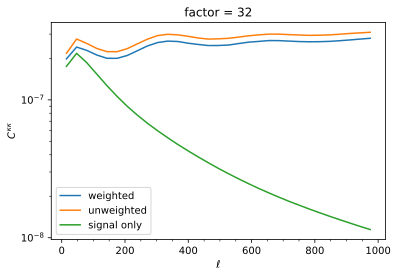

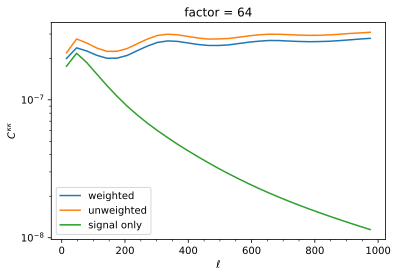

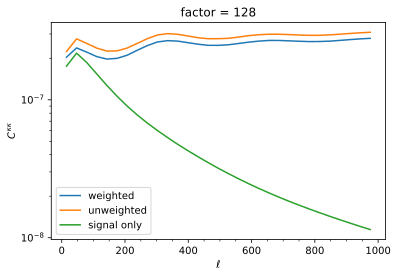

In [27]:
for i, Cl_kk_weighted in Cl_kk_weighted_list.items():
    fig, ax = plt.subplots(1,1)
    
    #Reconstructions
    plt.plot(ells_bin, Cl_kk_weighted, label='weighted')
    plt.plot(ells_bin, Cl_kk_unweighted_list[i], label='unweighted')
    
    #Signal Only
    plt.plot(ells_bin, Cls_kk_sig, label='signal only')
    
    plt.yscale('log')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C^{\kappa\kappa}$')
    plt.minorticks_on()
    plt.title(f'factor = {i}')
    plt.legend();

As shown above, the total power spectra seem correctly normalized. The average Cls from the sims also seem to agree with the individual sims from the ```sims covariance``` notebook, although Gerrit's individual sims are usually below the theory and Frank's are usually equal to it. It also shows that the weights will bring us closer to cosmic variance limited precision for low ells.

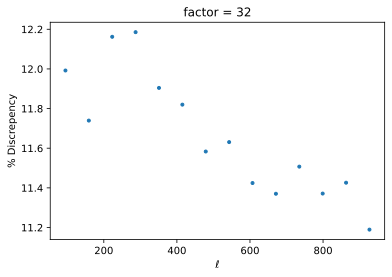

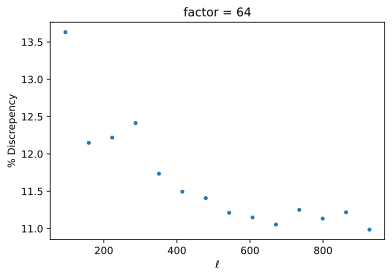

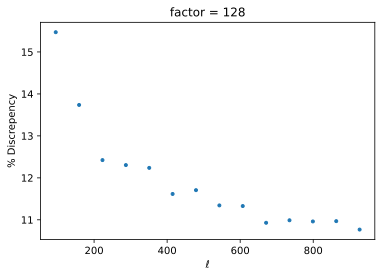

In [78]:
for i, Cl_kk_weighted in Cl_kk_weighted_list.items():
    fig, ax = plt.subplots(1,1)
    
    plt.plot(ells_bin, (Cl_kk_unweighted_list[i] - Cl_kk_weighted) / Cl_kk_weighted * 100 , '.')
    
#     plt.yscale('log')
    plt.xlabel(r'$\ell$')
    plt.ylabel('% Discrepency')
    plt.title(f'factor = {i}');

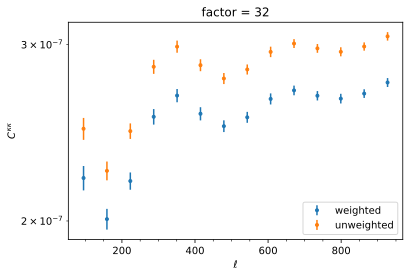

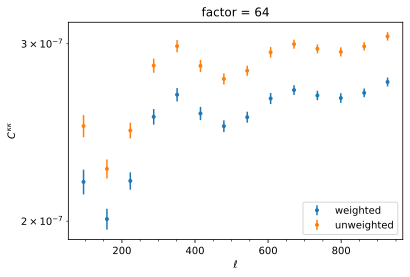

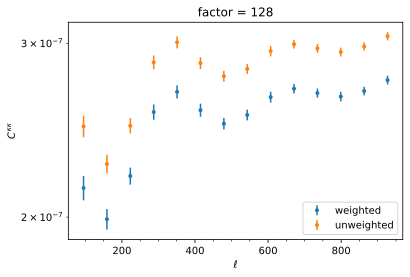

In [103]:
for i, factor in enumerate(factor_list):
    fig, ax = plt.subplots(1,1)
    
    plt.errorbar(ells_bin, avg_Cl_weighted[factor], yerr= err_weighted_list[factor] , fmt='.', label='weighted')
    plt.errorbar(ells_bin, avg_Cl_unweighted[factor], yerr= err_unweighted_list[factor] , fmt='.', label='unweighted')

        
#         knox_errs_weighted = np.sqrt(2 / (2*ells_bin+1) * avg_Cl_weighted[factor]**2)
#         knox_errs_unweighted = np.sqrt(2 / (2*ells_bin+1) * avg_Cl_unweighted[factor]**2)

#         plt.errorbar(ells_bin, avg_Cl_weighted[factor], yerr= knox_errs_weighted , fmt='.', label='weighted knox')
#         plt.errorbar(ells_bin, avg_Cl_unweighted[factor], yerr= knox_errs_unweighted , fmt='.', label='unweighted knox')
    
    
    plt.minorticks_on()
    plt.yscale('log')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C^{\kappa\kappa}$')
    plt.title(f'factor = {factor_list[i]}')
    plt.legend();

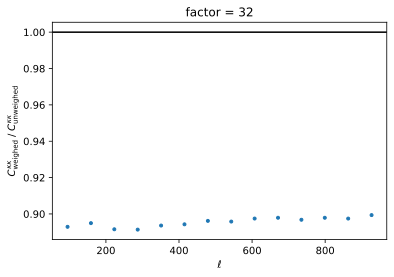

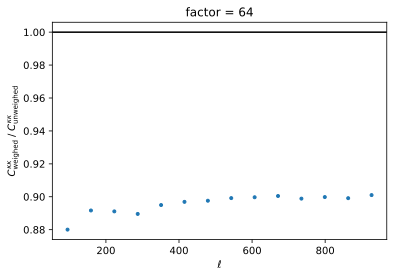

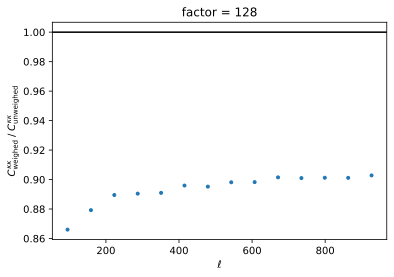

In [38]:
for i, factor in enumerate(factor_list):
    fig, ax = plt.subplots(1,1)
    
    plt.plot(ells_bin, avg_Cl_weighted[factor] / avg_Cl_unweighted[factor], '.')

    plt.axhline(y=1, color='black')
    
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C^{\kappa\kappa}_{\mathrm{weighed}} \;/\; C^{\kappa\kappa}_{\mathrm{unweighed}}$')
#     plt.ylim(1, 1.46)
    plt.title(f'factor = {factor_list[i]}');

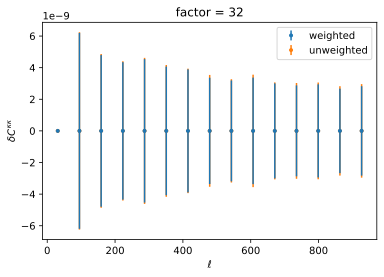

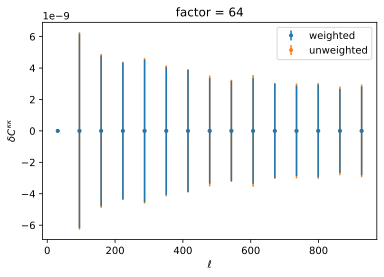

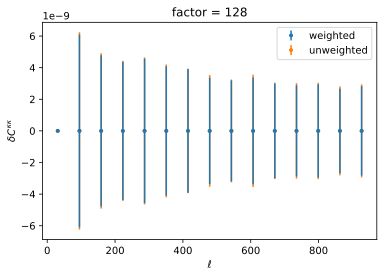

In [35]:
for i, factor in enumerate(factor_list):
    fig, ax = plt.subplots(1,1)
    
    plt.errorbar(ells_bin, np.zeros(len(ells_bin)), yerr= err_weighted_list[factor] , fmt='.', label='weighted')
    errplot = plt.errorbar(ells_bin, np.zeros(len(ells_bin)), yerr= err_unweighted_list[factor] , fmt='.', label='unweighted', zorder=0)
#     errplot[-1][0].set_linestyle('dashed')
  


#     plt.errorbar(ells_bin, np.zeros(len(ells_bin)), knox_errs_weighted , fmt='.', label='weighted')
#         plt.errorbar(ells_bin, np.zeros(len(ells_bin)), knox_errs_unweighted , alpha=0.5, fmt='.', label='unweighted')
     
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$\delta C^{\kappa\kappa}$')
    plt.title(f'factor = {factor_list[i]}')
    plt.legend();

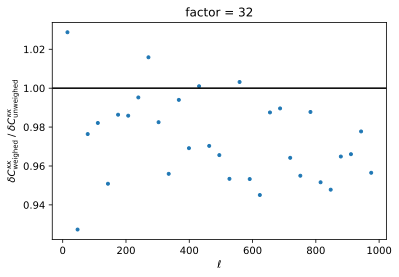

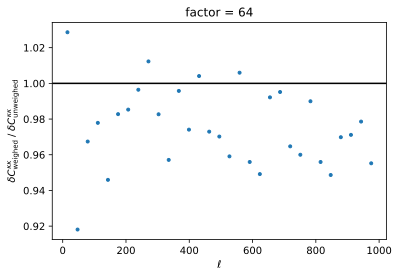

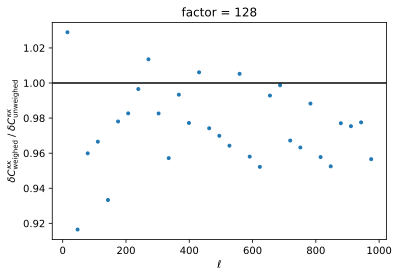

In [12]:
for i, factor in enumerate(factor_list):
    fig, ax = plt.subplots(1,1)

    plt.plot(ells_bin, err_weighted_list[factor] / err_unweighted_list[factor] , '.')

        
    plt.axhline(y=1, color='black')
    
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$\delta C^{\kappa\kappa}_{\mathrm{weighed}} \;/\; \delta C^{\kappa\kappa}_{\mathrm{unweighed}}$')
#     plt.ylim(1, 1.46)
    plt.title(f'factor = {factor_list[i]}');